In [140]:
import json
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
from climdist.data import load as cd_load
import seaborn as sns
import umap
from top2vec import Top2Vec
import colorcet as cc

In [2]:
df = cd_load('main', heading2=True, readability=True)

In [3]:
with open('../data/processed/entities_ruled_010522.json', 'r', encoding='utf8') as f:
    entities = json.load(f)

In [4]:
def sentences(until=None):
    with open('../data/processed/RZ_sentences.jsonl', 'r', encoding='utf8') as f:
        if until:
            for ix, line in enumerate(f.readlines()):
                if ix < until:
                    yield json.loads(line)
        else:
            for ix, line in enumerate(f.readlines()):
                yield json.loads(line)

In [154]:
sents = list(sentences())

## Create spans/concordances

In [6]:
def build_spans(sentences, entities, stretch, window, min_len=1):
    
    for entry, line in tqdm(zip(entities, sentences)):
        
        spans = []
        
        if len(entry['ents']) == 1 and min_len == 1:
            pos = entry['ents'][0][1]
            span_start = pos-window if pos >= window else 0
            span_end = pos+window if (len(line['text']) - pos) > window else len(line['text'])
            spans.append((span_start, span_end))
            
        if len(entry['ents']) >= min_len:
            positions = [ent[1] for ent in entry['ents']]
            distances = [i-j for i, j in zip(positions[1:], positions[:-1])] + ['last']
            #print(positions, distances)
            
            inside = False
            span_len = 0
            for i, pos in enumerate(positions):
                #print(i)
                dist = distances[i] # distance to next position
                if inside == False:
                    #print(entry['ents'][i], 'outside')
                    span_start = positions[i]-window if positions[i] >= window else 0
                    span_len += 1
                    #print('start', span_start)
                    inside = True
                    if dist == 'last':
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                    elif dist > stretch:
                        if span_len >= min_len:
                            span_end = positions[i]+window
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                            span_len = 0
                            inside = False 
                        else:
                            inside = False
                    else:
                        pass
                    
                elif inside == True:
                    span_len += 1
                    #print(entry['ents'][i], 'inside')
                    if dist == 'last':
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                    elif dist > stretch:
                        if span_len >= min_len:
                            span_end = positions[i]+window if (len(line['text']) - positions[i]) > window else len(line['text'])
                            #print(positions[i], len(line['text'])-positions[i])
                            #print('end', span_end)
                            spans.append((span_start, span_end))
                            inside = False
                        else:
                            span_len = 0
                            inside = False
                    else:
                        pass
                    
        else:
            pass
            
                    
        line['spans'] = spans

                    
    return [line for line in sentences if len(line['spans']) > 0]


def span_texts(entry):
    texts = []
    for span in entry['spans']:
        texts.append(entry['text'][span[0]:span[1]])
    return texts

In [99]:
spans2 = build_spans(sents, entities, stretch=100, window=20, min_len=3)
del sents

0it [00:00, ?it/s]

## top2vec

In [141]:
def build_top2vec_corpus(spans):

    corpus = {}
    for entry in spans:
        for i, span in enumerate(span_texts(entry)):
            corpus[str(entry['id'])+'_'+str(i)] = ' '.join(span)
    return corpus


def map_topics_to_main_df(t2v, df):
    
    document_ids = t2v.document_ids
    indices = [int(ID.split('_')[0]) for ID in document_ids]
    
    main_topics = [num[0] for x,y,z,num in
                  [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1, reduced=True)
                   for i in range(len(t2v.document_vectors))]   ]
    
    df_small = df.loc[indices]
    df_small['main_topic'] = main_topics
    
    return df_small


def topics_stackplot(topic_df, main_df, relative='local', timerange=range(1802,1889), rolling=True, savepath=None,
                     legend_pos='upper left'):

    matplotlib.rcParams['font.family'] = 'georgia'
    plt.figure(figsize=(15,7))
    
    local_articles = topic_df[(topic_df.year >= timerange[0]) &
                              (topic_df.year < timerange[-1])].groupby('year')['year'].count()
    
    total_articles = main_df[(main_df.year >= timerange[0]) &
                              (main_df.year < timerange[-1])].groupby('year')['year'].count()
    
    topics = sorted(topic_df['main_topic'].unique())
    data = []
    for top in topics:
        topic_counts = topic_df[topic_df['main_topic'] == top].groupby('year')['main_topic'].count().reindex(timerange)
        if relative == 'local':
            data.append((topic_counts/local_articles).fillna(0).rolling(5, min_periods=1).mean())
        elif relative == 'global':
            data.append((topic_counts/total_articles).fillna(0).rolling(5, min_periods=1).mean())
        elif relative == None:
            data.append((topic_counts).fillna(0).rolling(5, min_periods=1).mean())
        else:
            return('Pick "local", "global" or None for parameter "relative"')
            
    #plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Pastel1.colors)
    #col = sns.color_palette("tab20", len(topics))
    palette = sns.color_palette(cc.glasbey, n_colors=len(topics))
    plt.stackplot(timerange, data, labels=topics, colors=palette)
        
    plt.grid(b=True, which='both')
    plt.xticks(ticks=timerange, labels=[str(i) if i%5==0 else '' for i in timerange], fontsize=14)
    plt.tick_params(axis ='x', rotation = 45)
    if relative:
        plt.ylabel('% de tous les articles', fontsize=20)
    else:
        plt.ylabel("nb d'articles", fontsize=20)
    plt.yticks(fontsize=14)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize=12, loc=legend_pos, ncol=4)
    sns.set_style('ticks')
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    
    plt.show()
    
    
def get_words_and_headings(topics, t2v, topic_df):
    for num in topics:
        print(list(t2v.topic_words[num]))
        print('\n')
        print(topic_df.loc[topic_df.main_topic == num].heading2.value_counts()[:20])
        print('\n\n\n')

In [152]:
def train_and_plot_top2vec(min_len, reductions):
    
    print('Building corpus')
    t2v_corpus = build_top2vec_corpus(build_spans(sents, entities, stretch=100, window=20, min_len=min_len))
    print(f'corpus length: {len(t2v_corpus2)}')

    print('Training...')
    t2v = Top2Vec(documents=list(t2v_corpus.values()),
              document_ids=list(t2v_corpus.keys()),
              min_count=20,
              speed='learn',
              workers=8,
              embedding_model_path='../data/models/word2vec_270422/keyedvectors.txt')
    
    for num in reductions:
        print(f'Proceeding with reduction to {num} topics')
        t2v.hierarchical_topic_reduction(num)
        
        topic_vector_df = pd.DataFrame(index=t2v.document_ids, columns=range(1,301),
                              data=[vec for vec in t2v.document_vectors])
        reducer = umap.UMAP()
        umapped = reducer.fit_transform(topic_vector_df)
        
        main_topics = [num[0] for x,y,z,num in [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1, reduced=True)
                                     for i in range(len(t2v.document_vectors))]]

        umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
        umap_df['topic'] = main_topics
        
        plt.figure(figsize=(12,12))
        sns.scatterplot(data=umap_df, x='x', y='y', s=3, hue='topic',
                palette=sns.color_palette(cc.glasbey, n_colors=len(umap_df.topic.unique())))
        plt.legend(ncol=2)
        plt.show()
        
        topic_df = map_topics_to_main_df(t2v, df)
        topics_stackplot(topic_df, df, relative='global', timerange=range(1802,1889))
    
    return t2v

In [155]:
train_and_plot_top2vec(min_len=1, reductions=[40,30,20])

Building corpus


0it [00:00, ?it/s]

corpus length: 12291
Training...


2022-05-09 11:21:50,293 - top2vec - INFO - Pre-processing documents for training
2022-05-09 11:22:45,245 - top2vec - INFO - Creating joint document/word embedding


KeyboardInterrupt: 

### with 2-word spans

In [100]:
t2v_corpus2 = build_top2vec_corpus(spans2)

In [107]:
t2v = Top2Vec(documents=list(t2v_corpus2.values()),
              document_ids=list(t2v_corpus2.keys()),
              min_count=20,
              speed='learn',
              workers=8,
              embedding_model_path='../data/models/word2vec_270422/keyedvectors.txt')

2022-05-08 23:17:01,238 - top2vec - INFO - Pre-processing documents for training
2022-05-08 23:17:09,172 - top2vec - INFO - Creating joint document/word embedding
2022-05-08 23:20:15,095 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-08 23:20:30,949 - top2vec - INFO - Finding dense areas of documents
2022-05-08 23:20:31,991 - top2vec - INFO - Finding topics


In [41]:
#del t2v_corpus3

In [121]:
print(f'corpus length: {len(t2v_corpus2)}')
print(t2v.get_num_topics())
words, scores, nums = t2v.get_topics()
print(words[:10])

corpus length: 12291
45
[['augen' 'blick' 'leise' 'stimme' 'liebe' 'herz' 'rief' 'hand' 'madchen'
  'gedanken' 'draußen' 'mutter' 'worte' 'weiß' 'alten' 'fragte'
  'sonnenschein' 'geficht' 'gott' 'leben' 'wolken' 'gesicht' 'wort'
  'arme' 'thur' 'frau' 'lippen' 'herzen' 'lacheln' 'freunde' 'ferne'
  'dachte' 'blickte' 'seele' 'vater' 'fuhlte' 'antlitz' 'tone' 'stirn'
  'dunkle' 'auge' 'welt' 'kopf' 'brust' 'klang' 'schien' 'fußen' 'thun'
  'blicke' 'blicken']
 ['umsatze' 'handel_verkehr' 'lieferung' 'gedorrte' 'bedang'
  'roggen_basis' 'verkaufer' 'kauflust' 'waare' 'abgeber' 'kleinigkeiten'
  'hafer' 'notirungen' 'umsatzen' 'preise' 'zufuhr' 'loco'
  'borsen_handels' 'ungedorrter' 'umsatz' 'preisen' 'nehmer' 'roggen'
  'bedingen' 'pfundiger' 'kaufer' 'geschaft' 'productenborse' 'stimmung'
  'vorherrschend' 'producten' 'berkowez' 'bezahlt' 'inhaber'
  'unverandert' 'flauer' 'umgesetzt' 'getreidemarktes' 'unserem'
  'nominell' 'bafis' 'markte' 'schiffsverkehr' 'angeboten' 'nachfrage'
  

[[39, 0],
 [31, 1],
 [36, 2],
 [29, 7],
 [3],
 [8],
 [35, 38, 6],
 [4],
 [32, 17],
 [37, 44, 11],
 [5],
 [33, 10],
 [9],
 [28],
 [40, 13],
 [22],
 [12],
 [15],
 [16],
 [26],
 [30, 25],
 [42, 19],
 [24],
 [14],
 [21],
 [20],
 [18],
 [27],
 [23],
 [34, 43, 41]]

#### UMAP 3-word spans

In [136]:
topic_vector_df = pd.DataFrame(index=t2v.document_ids, columns=range(1,301),
                              data=[vec for vec in t2v.document_vectors])

In [137]:
reducer = umap.UMAP()
umapped = reducer.fit_transform(topic_vector_df)

In [138]:
main_topics = [num[0] for x,y,z,num in [t2v.search_topics_by_vector(t2v.document_vectors[i], num_topics=1, reduced=True)
                                     for i in range(len(t2v.document_vectors))]]

umap_df = pd.DataFrame(umapped, columns=['x', 'y'])
umap_df['topic'] = main_topics

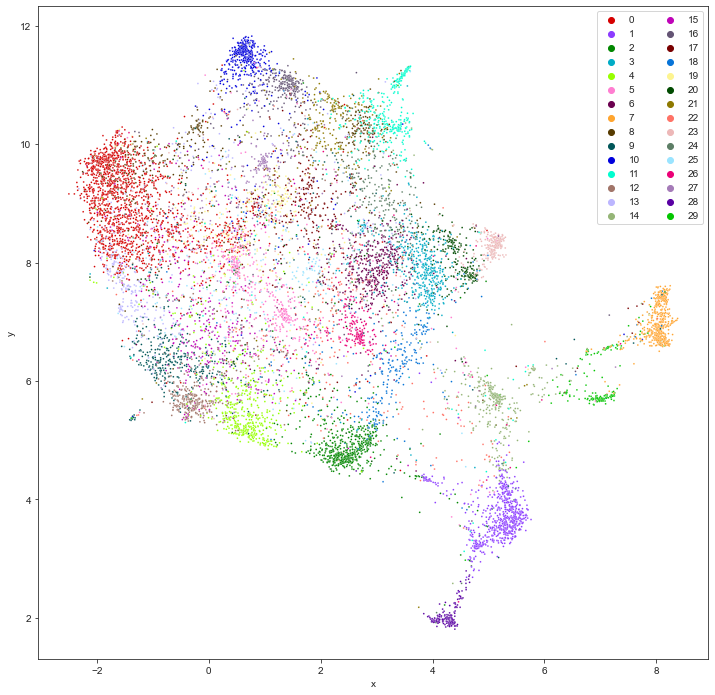

In [149]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=umap_df, x='x', y='y', s=3, hue='topic',
                palette=sns.color_palette(cc.glasbey, n_colors=len(umap_df.topic.unique())))
plt.legend(ncol=2)
plt.show()

#### stackplot 3-word spans

In [122]:
topic_df = map_topics_to_main_df(t2v, df)

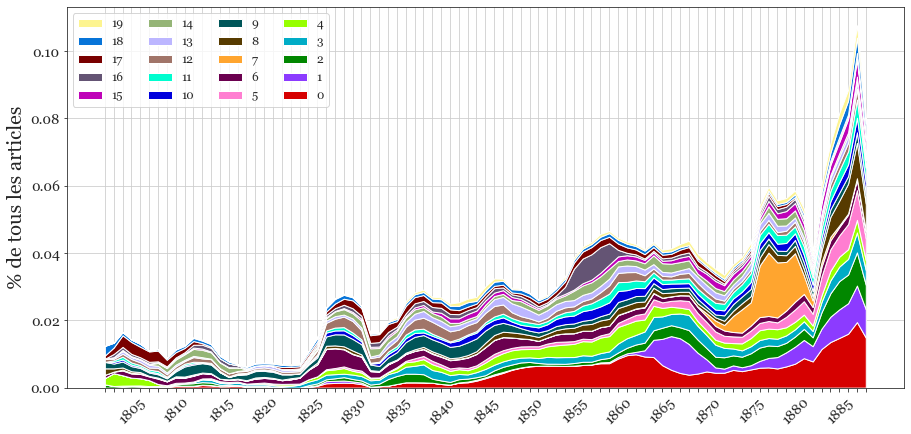

In [150]:
topics_stackplot(topic_df, df, relative='global', timerange=range(1802,1889))

In [134]:
get_words_and_headings([6], t2v=t2v, topic_df=topic_df)

['uberschwemmt', 'uberschwemmung', 'brucken', 'ueberschwemmung', 'fluthen', 'eingesturzt', 'fortgerissen', 'hauser', 'ortschaften', 'angerichtet', 'heimgesucht', 'weggerissen', 'wasser', 'wolkenbruch', 'ungluck', 'ertrunken', 'verheerungen', 'angeschwollen', 'menschenleben', 'uberschwemmten', 'weggeschwemmt', 'wohnungen', 'schaden', 'fortgeschwemmt', 'verwustet', 'einsturz', 'zerstort', 'niederungen', 'weichsel', 'hochwasser', 'damme', 'vernichtet', 'uberfluthet', 'niederung', 'deich', 'retten', 'umgekommen', 'einwohner', 'gelegenen', 'menschen', 'trummern', 'flusse', 'wolkenbruche', 'dorfer', 'verwustungen', 'ausgetreten', 'gewasser', 'verwustung', 'bewohner', 'betroffen']


Inland                       37
Vermischtes                  32
Deutschland                  29
London                       28
Paris                        26
Berlin                       18
Neueste Nachrichten          16
Wien                         16
Frankreich                    9
Deutsches Reich            

### with 4-word spans

In [527]:
t2v_corpus4 = build_top2vec_corpus(spans4)

In [528]:
t2v4 = Top2Vec(documents=list(t2v_corpus4.values()),
              document_ids=list(t2v_corpus4.keys()),
              min_count=20,
              embedding_model_path='../data/models/word2vec_270422/keyedvectors.txt',
              workers=-1)

2022-05-08 22:12:43,306 - top2vec - INFO - Pre-processing documents for training
2022-05-08 22:12:48,839 - top2vec - INFO - Creating joint document/word embedding
2022-05-08 22:12:50,343 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-08 22:13:07,912 - top2vec - INFO - Finding dense areas of documents
2022-05-08 22:13:09,295 - top2vec - INFO - Finding topics


In [529]:
print(t2v4.get_num_topics())

31


In [530]:
topic_vector_df4 = pd.DataFrame(index=t2v4.document_ids, columns=range(1,301),
                              data=[vec for vec in t2v4.document_vectors])

In [531]:
main_topics4 = [num[0] for x,y,z,num in [t2v4.search_topics_by_vector(t2v4.document_vectors[i], num_topics=1, reduced=False)
                                     for i in range(len(t2v4.document_vectors))]]

In [532]:
reducer4 = umap.UMAP()
umapped4 = reducer.fit_transform(topic_vector_df4)

In [533]:
umap_df4 = pd.DataFrame(umapped4, columns=['x', 'y'])
umap_df4['topic'] = main_topics4

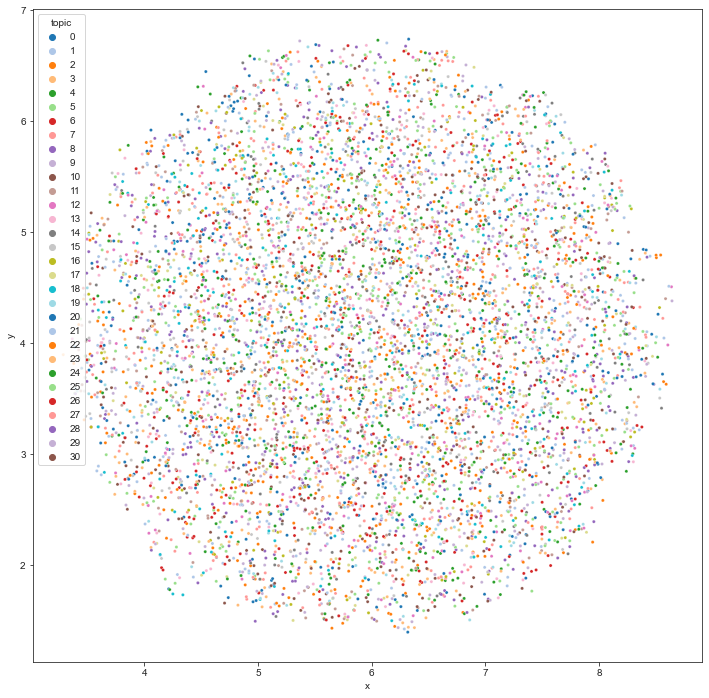

In [534]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=umap_df4, x='x', y='y', s=10, hue='topic', palette='tab20')
plt.show()

## doc2vec model

In [142]:
def build_doc2vec_corpus(spans):
    
    corpus = []
    for entry in spans:
        for i, span in enumerate(span_texts(entry)):
            corpus.append(doc2vec.TaggedDocument(span, [str(entry['id'])+'_'+str(i)]))
    return corpus


def raw_text(ID, df=df, spans=spans):
    
    entry_id, span_id = ID.split('_')
    span_entry = [entry for entry in spans if entry['id'] == int(entry_id)][0]
    start, stop = span_entry['spans'][int(span_id)]
    
    start_per = start/len(span_entry['text'])
    stop_per = stop/len(span_entry['text'])
    
    full_text = df.loc[int(entry_id), 'full_text']
    
    text_start = round(start_per * len(full_text))
    text_stop = round(stop_per * len(full_text))
    
    return full_text[text_start:text_stop]


def similarity_example(ix):
    ID = '_'.join(corpus2[ix].tags)
    print(raw_text(ID))
    for i, sim in model2.dv.most_similar(inferred_vector):
        print('------------------------------------------------------------------------------------------------------')
        print(raw_text(i))

In [67]:
corpus = build_doc2vec_corpus(spans)

In [123]:
model = doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=40)

In [124]:
model.build_vocab(corpus)

In [125]:
start = time.perf_counter()
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
stop = time.perf_counter()
print(f'Finished in {round(stop-start, 2)} seconds')

Finished in 142.91 seconds


In [126]:
vec_df = pd.DataFrame(index=model.dv.index_to_key,
                      data=[model.dv[ix] for ix in model.dv.index_to_key])

## HDBSCAN

In [130]:
def get_tsne_df(vec_df):
    
    tsne = TSNE(2)
    tsne_result = tsne.fit_transform(vec_df)
    tsne_result_df = pd.DataFrame(
        {'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': vec_df.index}
    )
    
    return tsne_result_df

In [133]:
tsne_df50 = get_tsne_df(vec_df)

c:\users\krister\climdist\v_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\krister\climdist\v_env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [202]:
hdb = hdbscan.HDBSCAN(min_samples=100, min_cluster_size=300, core_dist_n_jobs=8)

In [215]:
hdb_labels = hdb.fit_predict(tsne_df)

In [216]:
tsne_df['topic'] = hdb_labels

In [217]:
tsne_df.loc[:,'topic'].value_counts()

 2    3986
-1    2148
 5    1792
 6    1415
 4    1158
 1     861
 0     512
 3     419
Name: topic, dtype: int64

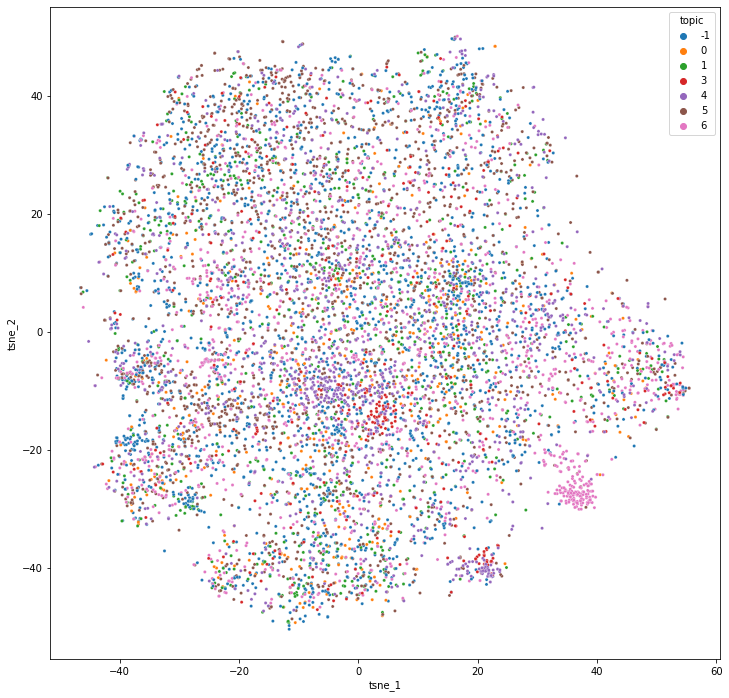

In [218]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=tsne_df[tsne_df.topic != 2], x='tsne_1', y='tsne_2', s=10, hue='topic', palette='tab10')
plt.show()

In [143]:
def pca_plot(model):
    
    df = pd.DataFrame(index=model.dv.index_to_key,
                  data=[model.dv[ix] for ix in model.dv.index_to_key])
    
    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    
    pca_df = pd.DataFrame(data=pca_data, index=df.index, columns=labels)

    plt.figure(figsize=(10,10))
    
    plt.scatter(pca_df.PC1, pca_df.PC2, s=1)
    plt.xlabel('PC1 - {0}%'.format(round(per_var[0], 2)))
    plt.ylabel('PC2 - {0}%'.format(round(per_var[1], 2)))

            
    plt.show()

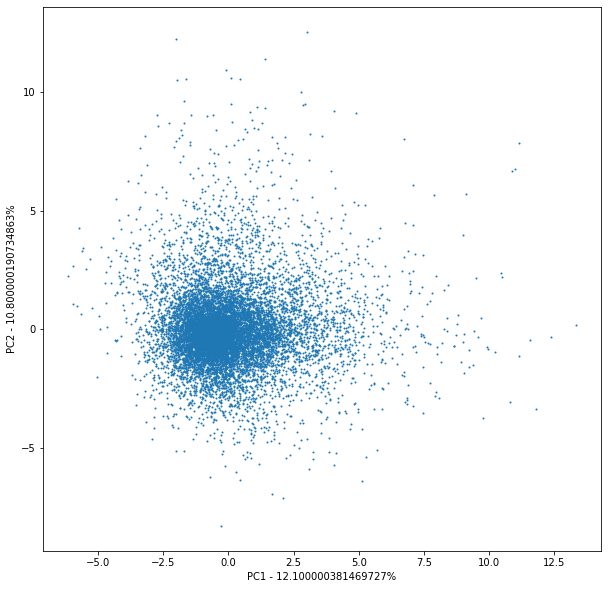

In [144]:
pca_plot(model)

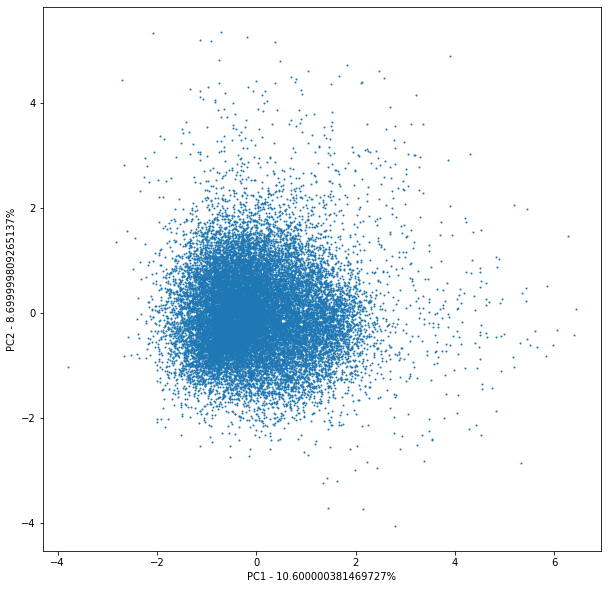

In [603]:
pca_plot(model2)

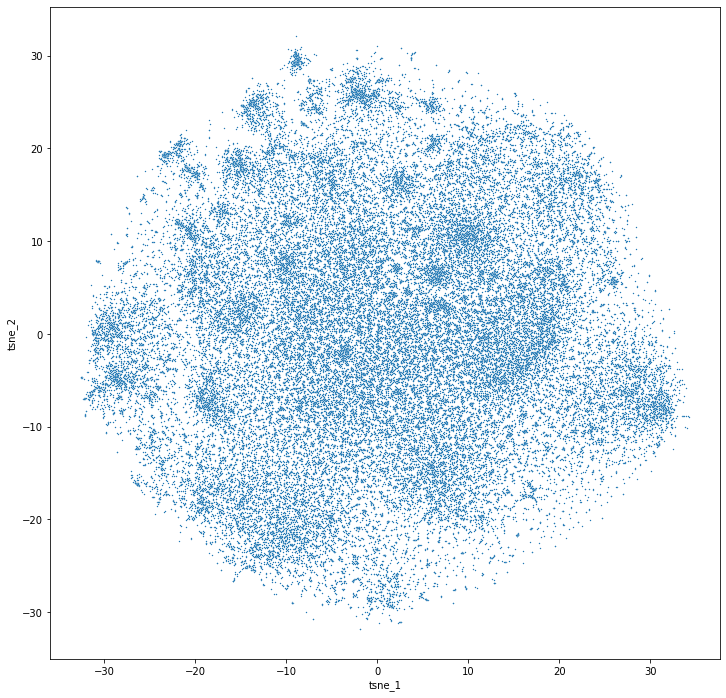

In [613]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=tsne_df1, x='tsne_1', y='tsne_2', s=2)
plt.show()

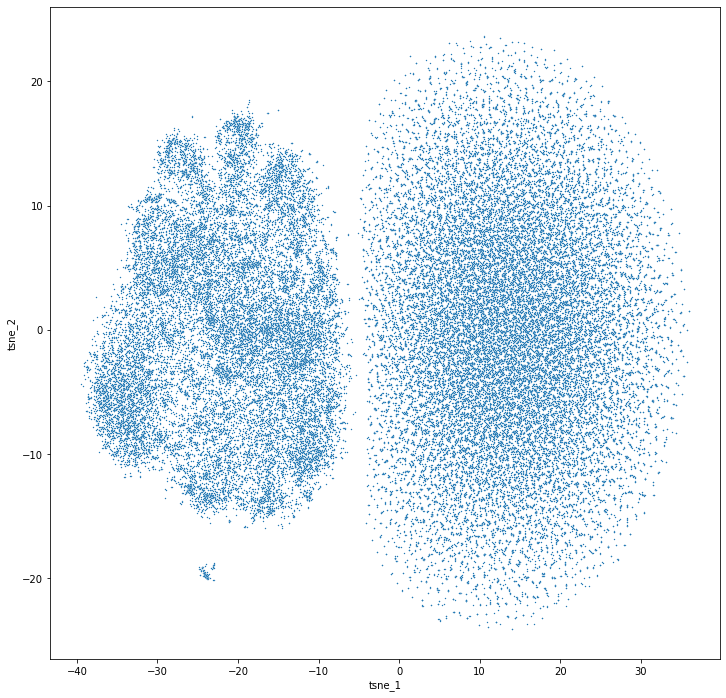

In [607]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=tsne_df2, x='tsne_1', y='tsne_2', s=2)
plt.show()